In [1]:
# Autoreload 
%load_ext autoreload
%autoreload 2

device = 'cuda'

In [2]:
import torch 
import matplotlib.pyplot as plt

# Elemental Mapping

An element map is an image showing the spatial distribution of elements in a sample. Because it is acquired from a polished section, it is a 2D section through the unknown sample. Element maps are extremely useful for displaying element distributions in textural context, particularly for showing compositional zonation.

### Fully Connected Model

In [3]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

In [4]:
training_images = ['gogo', 'dionisios', 'fanourios', 'odigitria', 'minos']
test_images = ['saintjohn']

In [6]:
band_range = (80, 2128)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=training_images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(80, 2128), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [45]:
# Define the Fully Connected Model
from Elemental_Mapping.models.FullyConnectedModel import FullyConnectedModel

in_features = band_range[1]-band_range[0]
out_features = len(dataset.target_elems)
fcn = FullyConnectedModel(in_features=in_features, out_features=out_features, hidden_dims=[1024, 512, 256, 64])
fcn.to(device)

FullyConnectedModel(
  (layers): ModuleList(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [46]:
# Define Criterion and optimizer
from Elemental_Mapping.loss_functions.AdaptiveL1Loss import AdaptiveL1Loss
import torch.optim as optim
    
criterion = AdaptiveL1Loss()
fcn_optimizer = optim.Adam(fcn.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = fcn.train(train_loader, fcn_optimizer, criterion, epochs=1, device=device)
    val_loss, pred = fcn.eval(val_loader, criterion, device=device)
    print(f'Epoch: {epoch}, Train Loss: {round(train_loss, 4)}, Val Loss: {round(val_loss, 4)}')
    # Save model 
    torch.save(fcn.state_dict(), f'fcn_{fcn.hidden_dims}_best.pt')

In [49]:
# Load state dict
fcn.load_state_dict(torch.load(f'fcn_{fcn.hidden_dims}_best.pt'))

<All keys matched successfully>

In [14]:
testset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=test_images,
    sample_step = 1,
    device='cuda',
    band_range=(80, 2128),
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
from utils import open_target_image
real = open_target_image(f'/home/igeor/MSC-THESIS/data/h5/elem_maps/{test_images[0]}.dat')
h, w, _ = real.shape
real = torch.tensor(real).to(device)

In [50]:
score, pred = fcn.eval(test_loader, criterion, device=device)
pred = pred.reshape(h, w, len(testset.target_elems))
print(f'Loss: {round(score, 4)}')

Loss: 43.1865


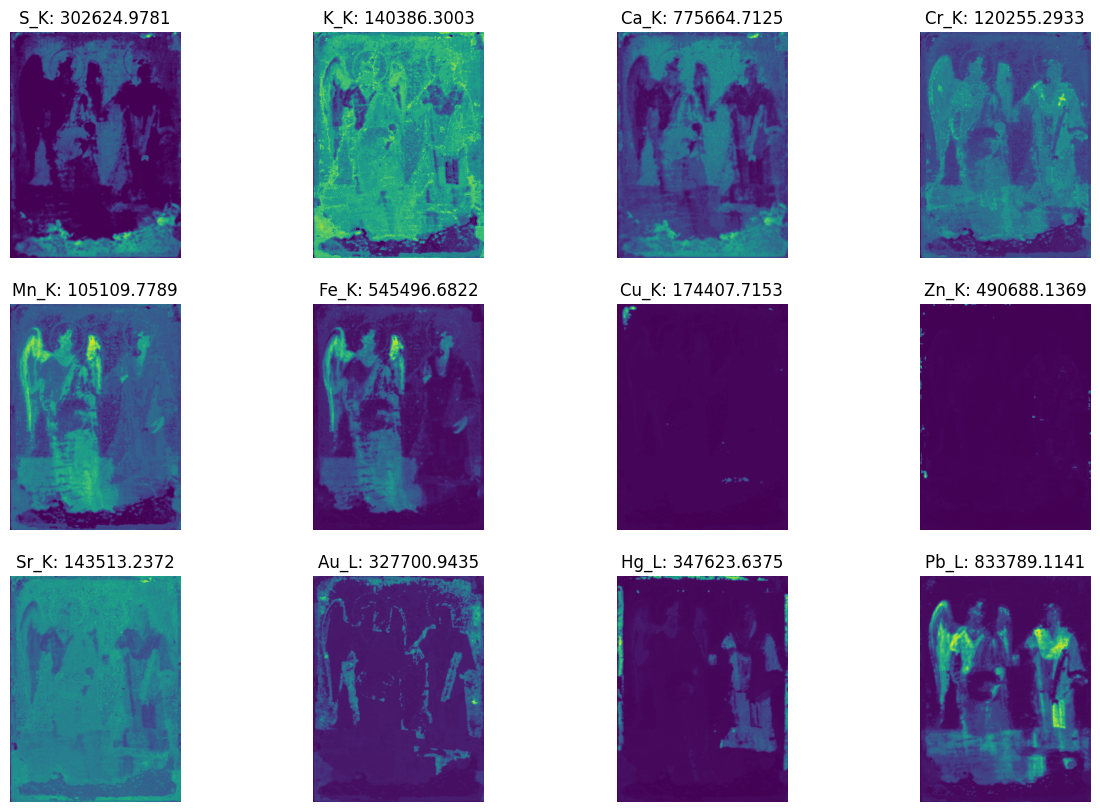

In [51]:
# plot all 12 bands
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    i_pred = pred[:,:,i].cpu().detach()
    i_real = real[:,:,i].cpu().detach()
    
    loss = criterion(i_pred, i_real)
    ax.imshow(i_pred)
    
    ax.set_title(f'{testset.target_elems[i]}: {round(loss.item(), 4)}')
    ax.axis('off')

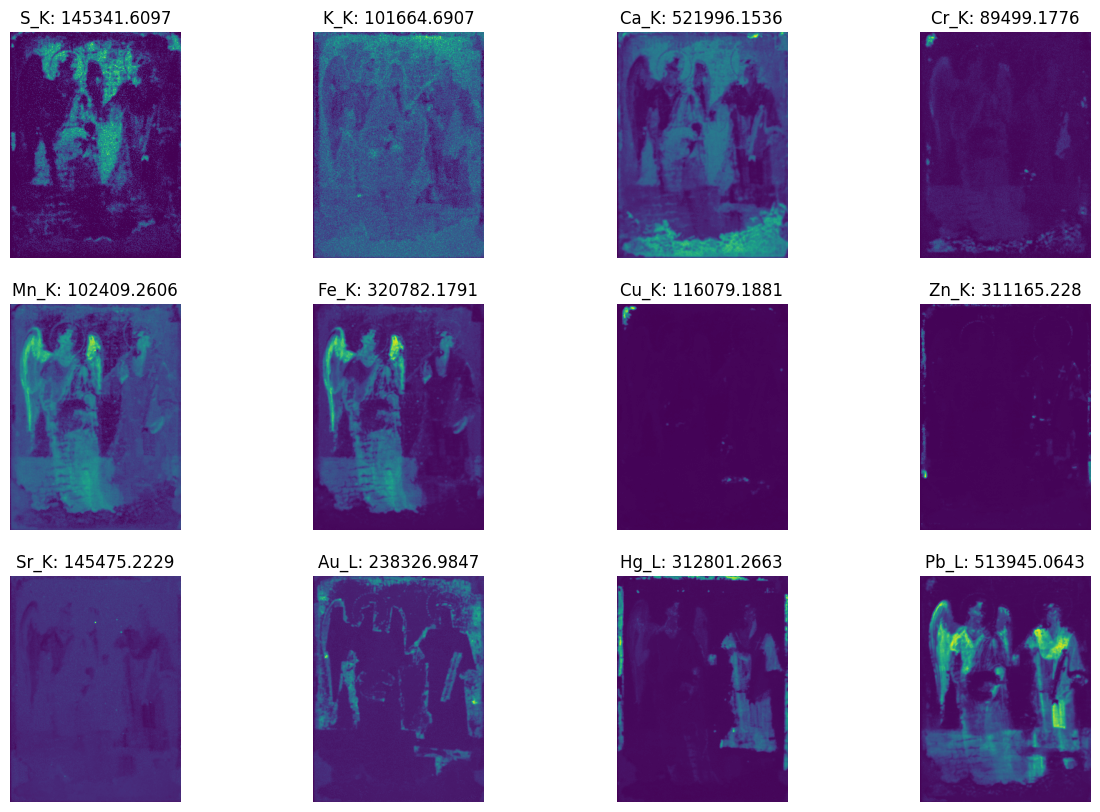

In [44]:
# plot all 12 bands
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    i_pred = pred[:,:,i].cpu().detach()
    i_real = real[:,:,i].cpu().detach()
    
    loss = criterion(i_pred, i_real)
    ax.imshow(i_pred)
    
    ax.set_title(f'{testset.target_elems[i]}: {round(loss.item(), 4)}')
    ax.axis('off')

##### Explainability

In [ ]:
# Check the weights of the first layer of the network
weights = fcn.fc1.weight.cpu().detach().numpy()